# Example 4: Cross Channel Correlation Map

In this example we demonstrate the cross channel correlation map calculation. This image will be useful for later death signal identification.

In [27]:
import dask_image.imread
import matplotlib.pyplot as plt
%matplotlib inline

from cyto.preprocessing.cross_channel_correlation import *
import os

from aicsimageio.writers.ome_tiff_writer import OmeTiffWriter

## Load Data

Immunofluorescence staining setup in our cytotoxicity dataset

| Channels      | Stain         |
| ------------- | ------------- |
| Cancer Cells      | GFP |
| Death Signal      | PI      |
| T Cells | DRCT      |

In [2]:
GFP_FILE_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/register_denoise_gamma/ch0/*.tif"
PI_FILE_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/register_denoise_gamma/ch1/*.tif"
DRCT_FILE_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/register_denoise_gamma/ch2/*.tif"

For lazy loading of time splitted TIFF images, Dask Image reader is recommended

In [5]:
GFP_image = dask_image.imread.imread(GFP_FILE_PATTERN)
PI_image = dask_image.imread.imread(PI_FILE_PATTERN)
DRCT_image = dask_image.imread.imread(DRCT_FILE_PATTERN)

GFP_image

dask.array<_map_read_frame, shape=(12949, 2400, 2400), dtype=uint16, chunksize=(1, 2400, 2400), chunktype=numpy.ndarray>

## Visualize the loaded image data

Text(0.5, 1.0, 'DRCT')

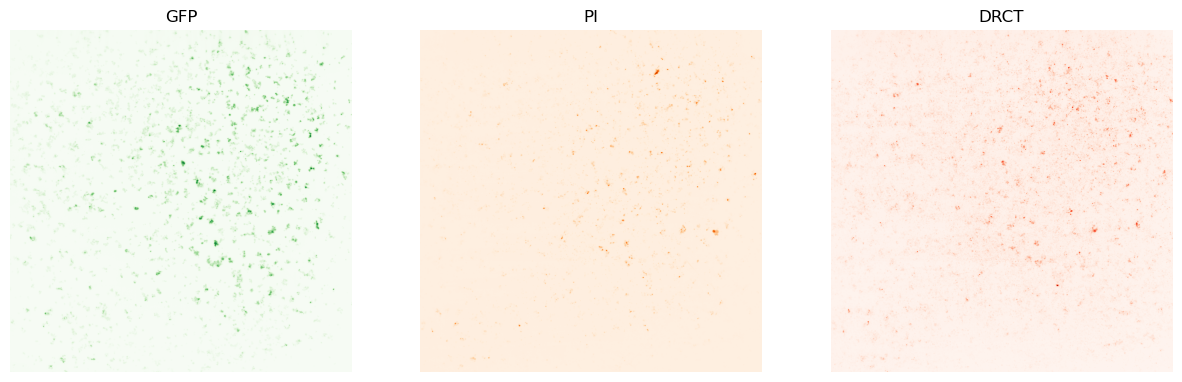

In [24]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

axs[0].imshow(GFP_image[0,:,:].T,cmap="Greens")
axs[0].set_axis_off()
axs[0].set_title("GFP")

axs[1].imshow(PI_image[0,:,:].T,cmap="Oranges")
axs[1].set_axis_off()
axs[1].set_title("PI")

axs[2].imshow(DRCT_image[0,:,:].T,cmap="Reds")
axs[2].set_axis_off()
axs[2].set_title("DRCT")

## Cross Pixel Correlation

In [7]:
FRAMES = 2000

### Cancer cells
GFP vs PI correlation

In [8]:
images = {}
images[0] = GFP_image.T[:,:,:FRAMES].persist()
images[1] = PI_image.T[:,:,:FRAMES].persist()

ccc = CrossChannelCorrelation(mode="SLICE")
res = ccc({"images": images})

cancer_corr_map = res["output"]

### T cells
PI vs DRCT correlation

In [18]:
images = {}
images[0] = PI_image.T[:,:,:FRAMES].persist()
images[1] = DRCT_image.T[:,:,:FRAMES].persist()

ccc = CrossChannelCorrelation(mode="SLICE")
res = ccc({"images": images})

tcell_corr_map = res["output"]


100%|██████████| 3/3 [00:00<00:00,  7.99it/s]


### Correlation map

Text(0.5, 1.0, 'T Cell Death Correlation Map')

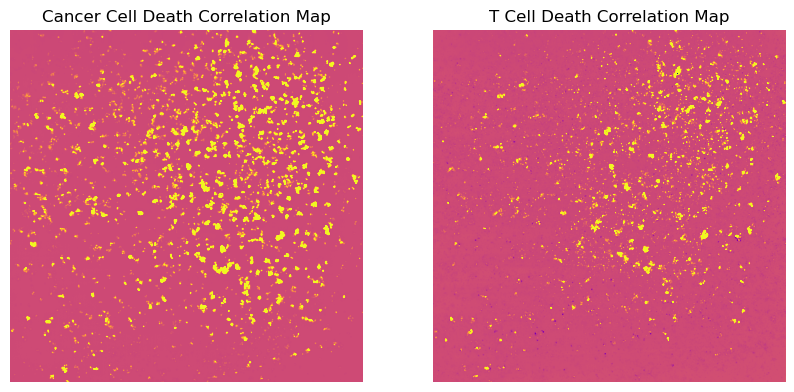

In [22]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].imshow(cancer_corr_map[:,:,0],cmap="plasma",vmin=32768-1000,vmax=32768+1000)
axs[0].set_axis_off()
axs[0].set_title("Cancer Cell Death Correlation Map")

axs[1].imshow(tcell_corr_map[:,:,0],cmap="plasma",vmin=32768-1000,vmax=32768+1000)
axs[1].set_axis_off()
axs[1].set_title("T Cell Death Correlation Map")

In [28]:
# store the result
output_dir =  "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/register_denoise_gamma_cc"
os.makedirs(output_dir,exist_ok=True)

for c in ["cancer","tcell"]:
    os.makedirs(os.path.join(output_dir,c),exist_ok=True)

for t in tqdm(range(FRAMES)):
    output_file = os.path.join(output_dir, "cancer","im{}.tif".format(str(t).zfill(5)))
    OmeTiffWriter.save(cancer_corr_map[:,:,t].T, output_file, dim_order="YX")

    output_file = os.path.join(output_dir, "tcell","im{}.tif".format(str(t).zfill(5)))
    OmeTiffWriter.save(cancer_corr_map[:,:,t].T, output_file, dim_order="YX")

  0%|          | 0/3 [00:00<?, ?it/s]/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/ome_types/_convenience.py:112: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
100%|██████████| 3/3 [00:01<00:00,  2.58it/s]
